In [1]:
#importing packages
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from tensorflow.keras import layers, applications, optimizers
from keras import regularizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, ZeroPadding2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy import ndimage, misc

from imgaug import augmenters as iaa
import imgaug as ia

import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import imutils
import random
import pickle
import cv2
import os
import argparse
import re
from PIL import Image
from numpy import *
from glob import glob
from datetime import datetime
from shutil import copyfile
 
import pandas as pd    
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell #multiple outputs in notebook
InteractiveShell.ast_node_interactivity = "all"            #

random.seed(42)

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.backend.backend())

1.15.0
tensorflow


In [0]:
def plotImages(images_arr, name):
    random.shuffle(images_arr)
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'), cmap = 'gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig('{}.png'.format(name))

In [0]:
#google Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [0]:
#google Colab
!unzip drive/My\ Drive/notes_aug_heavy_lily.zip

OUTPUT = "notes_aug_heavy/"

In [0]:
# initialize image dimensions
IMAGE_DIMS = (158, 100, 3)
scale_percent = 100

width = int(IMAGE_DIMS[1] * scale_percent / 100)
height = int(IMAGE_DIMS[0] * scale_percent / 100)

In [0]:
# grab the image paths and randomly shuffle them
random.seed(42)
imagePaths = sorted(list(paths.list_images(OUTPUT)))
random.shuffle(imagePaths)

# initialize the data and labels
images_train = []
data_train = []
noteLabels = []
durationLabels = []

# create preprocessed lists of images
for imagePath in imagePaths:
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (width, height))
    ret1, image = cv2.threshold(image,127,255,cv2.THRESH_OTSU)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) #TL model needs colored, 3 channel images as input
    image = ndimage.median_filter(image, size=2)
    images_train.append(image)
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    data_train.append(image)
    
    # extract set of class labels from the image path and update the labels
    filename = imagePath.split(os.path.sep)[-1]
    duration = re.search('(breve|longa|\d\.?)', filename).group()
    note = re.search('([a-z]\'*|^\w{1}\'*)', filename).group()
    noteLabels.append(note)
    durationLabels.append(duration)

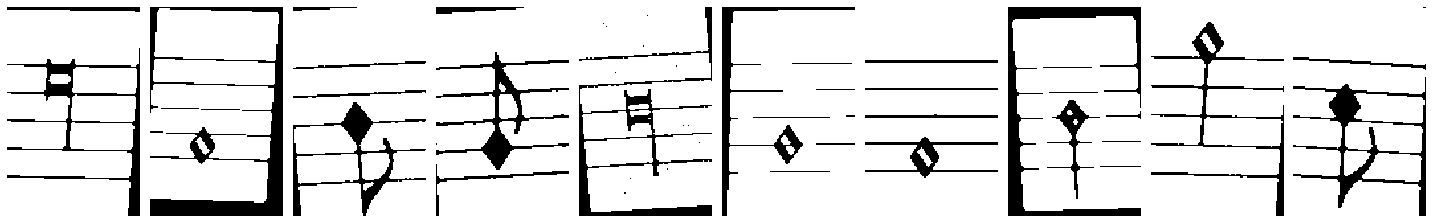

In [9]:
plotImages(images_train, 'images_train')

In [10]:
data_train = np.array(data_train)

# do some checks
data_train.shape
set(noteLabels)
set(durationLabels)
len(set(map(len, (data_train, noteLabels, durationLabels)))) == 1 #check if length of lists is the same

(19800, 158, 100, 3)

{"a'", "b'", "c''", "d'", "d''", "e'", "e''", "f'", "f''", "g'", "g''"}

{'1', '2', '4', '8', 'breve', 'longa'}

True

In [0]:
# convert the label lists to NumPy arrays prior to binarization
noteLabels = np.array(noteLabels)
durationLabels = np.array(durationLabels)
 
# binarize both sets of labels
noteLB = LabelBinarizer()
durationLB = LabelBinarizer()
noteLabels = noteLB.fit_transform(noteLabels)
durationLabels = durationLB.fit_transform(durationLabels)

trainX, testX, trainNoteY, testNoteY, trainDurationY, testDurationY = train_test_split(data_train,
                                    noteLabels, durationLabels, random_state=666, train_size=0.75)

In [12]:
# do some checks

print("We have {} training images and {} test images, with a total of {} images. The images have a height of {} and a width of {} with {} channel(s). There are {} different note classes and {} different duration classes.".format(trainX.shape[0], testX.shape[0], data_train.shape[0], data_train.shape[1], data_train.shape[2], data_train.shape[3], trainNoteY.shape[1], trainDurationY.shape[1]))

We have 14850 training images and 4950 test images, with a total of 19800 images. The images have a height of 158 and a width of 100 with 3 channel(s). There are 11 different note classes and 6 different duration classes.


# Transfer Model

In [0]:
# base_model = applications.inception_v3.InceptionV3(weights = "imagenet", include_top=False, input_shape = (158, 100, 3))
base_model = keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape = (158, 100, 3))

In [0]:
for layer in base_model.layers[:28]:
    layer.trainable = False

In [16]:
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb2f918deb8>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb2f9e36e10>,conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb2f9e36c18>,conv1_conv,False
3,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb2f97642e8>,pool1_pad,False
4,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb2f9e36d30>,pool1_pool,False
5,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7fb2f9764320>,conv2_block1_preact_bn,False
6,<tensorflow.python.keras.layers.core.Activation object at 0x7fb2f98d1898>,conv2_block1_preact_relu,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb2f96c3240>,conv2_block1_1_conv,False
8,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7fb2f96e6550>,conv2_block1_1_bn,False
9,<tensorflow.python.keras.layers.core.Activation object at 0x7fb2f968c828>,conv2_block1_1_relu,False


In [0]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)
note_output = Dense(len(noteLB.classes_), activation='softmax', name = "note_output")(x)
duration_output = Dense(len(durationLB.classes_), activation='softmax', name = "duration_output")(x)

model = Model(inputs=base_model.input, outputs=[note_output, duration_output])

In [18]:
# do some checks
model.summary()
model.input_shape
model.output_shape

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 158, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 164, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 79, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 81, 52, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

(None, 158, 100, 3)

[(None, 11), (None, 6)]

In [0]:
# compile model
epochs = 80
batch_size = 128

# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
    "note_output": "categorical_crossentropy",
    "duration_output": "categorical_crossentropy",}
lossWeights = {"note_output": 1.0, "duration_output": 1.0}
 
# initialize the optimizer and compile the model
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
nadam = optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=adam, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

In [0]:
# callbacks
early_stopping = EarlyStopping(monitor='val_note_output_acc', patience=12, mode = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(patience=8, monitor='val_loss', factor=0.3, min_lr=0.00001, cooldown=1, verbose=1)

checkpoint = ModelCheckpoint("/Users/annaleid/Documents/Jordy/Trained Models/",
        monitor='val_acc', 
        save_best_only=True, 
        mode='max',
        verbose=0)

In [21]:
# # train the network to perform multi-output classification
H = model.fit(trainX, {"note_output": trainNoteY, "duration_output": trainDurationY},
    validation_data=(testX, {"note_output": testNoteY, "duration_output": testDurationY}),
    epochs=epochs,
    verbose=1,
    callbacks = [reduce_lr, early_stopping])

Train on 14850 samples, validate on 4950 samples
Epoch 1/80
14850/14850 [==============================] - 160s 11ms/sample - loss: 0.5946 - note_output_loss: 0.3661 - duration_output_loss: 0.2275 - note_output_acc: 0.8923 - duration_output_acc: 0.9327 - val_loss: 0.4964 - val_note_output_loss: 0.2399 - val_duration_output_loss: 0.2558 - val_note_output_acc: 0.9378 - val_duration_output_acc: 0.9446
Epoch 2/80
14850/14850 [==============================] - 148s 10ms/sample - loss: 0.1287 - note_output_loss: 0.0663 - duration_output_loss: 0.0626 - note_output_acc: 0.9839 - duration_output_acc: 0.9858 - val_loss: 7.2631 - val_note_output_loss: 5.4067 - val_duration_output_loss: 1.8502 - val_note_output_acc: 0.6683 - val_duration_output_acc: 0.7721
Epoch 3/80
14850/14850 [==============================] - 148s 10ms/sample - loss: 0.1205 - note_output_loss: 0.0663 - duration_output_loss: 0.0540 - note_output_acc: 0.9870 - duration_output_acc: 0.9869 - val_loss: 0.0517 - val_note_output_loss

Text(0.5, 1.0, 'Total loss')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss for note_output_loss')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss for duration_output_loss')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Loss')

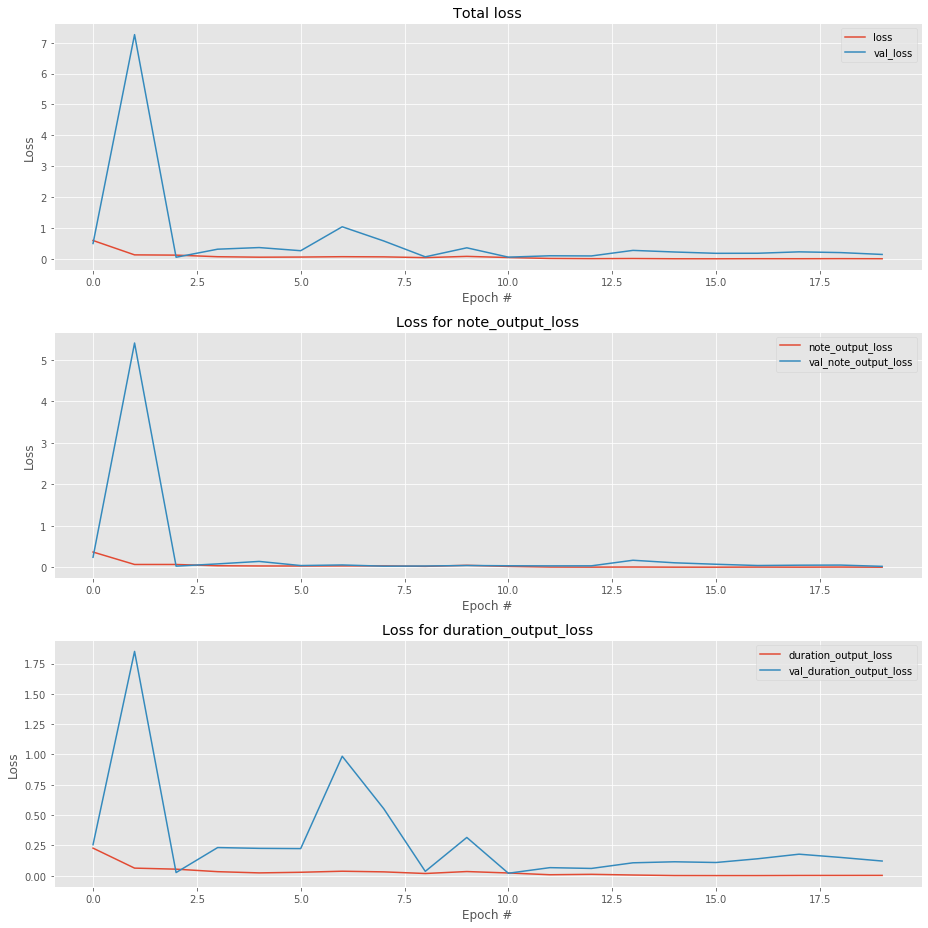

In [22]:
n_epochs = len(H.history['loss'])

# plot the total loss, category loss, and color loss
lossNames = ["loss", "note_output_loss", "duration_output_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
 
# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(np.arange(0, n_epochs), H.history[l], label=l)
    ax[i].plot(np.arange(0, n_epochs), H.history["val_" + l],
        label="val_" + l)
    ax[i].legend()
 
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

Text(0.5, 1.0, 'Accuracy for note_output_acc')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Accuracy for duration_output_acc')

Text(0.5, 0, 'Epoch #')

Text(0, 0.5, 'Accuracy')

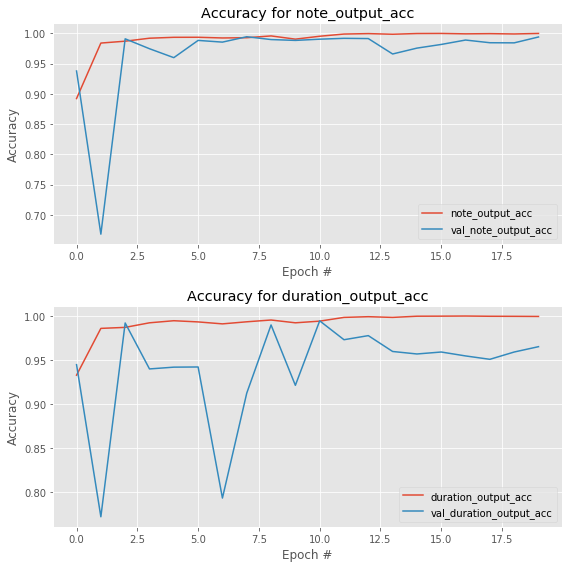

In [23]:
# create a new figure for the accuracies
accuracyNames = ["note_output_acc", "duration_output_acc"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(8, 8))
 
# loop over the accuracy names
for (i, l) in enumerate(accuracyNames):
    # plot the loss for both the training and validation data
    ax[i].set_title("Accuracy for {}".format(l))
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Accuracy")
    ax[i].plot(np.arange(0, n_epochs), H.history[l], label=l)
    ax[i].plot(np.arange(0, n_epochs), H.history["val_" + l],
        label="val_" + l)
    ax[i].legend()
 
# save the accuracies figure
plt.tight_layout()

# Test Images

In [0]:
#Google Colab
!unzip drive/My\ Drive/testimages.zip

In [0]:
folder_test = "testimages/"
imagePaths = sorted(list(paths.list_images(folder_test)))

##### Create list with arrays and labels of test images

# initialize the data and labels
images_test_original = []
images_test = []
data_test = []
noteLabels_test = []
durationLabels_test = []

for imagePath in imagePaths:
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    images_test_original.append(image)
    image = cv2.resize(image, (width, height))
    ret1, image = cv2.threshold(image, 50,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) #TL model needs colored, 3 channel images as input
    image = ndimage.median_filter(image, size=2)
    images_test.append(image)
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    data_test.append(image)
    
    # extract set of class labels from the image path and update the labels
    # update the respective lists
    filename = imagePath.split(os.path.sep)[-1]
    duration = re.search('(breve|longa|maxima|\d\.?)', filename).group()
    note = re.search('([a-z]\'*|^\w{1}\'*)', filename).group()
    noteLabels_test.append(note)
    durationLabels_test.append(duration)

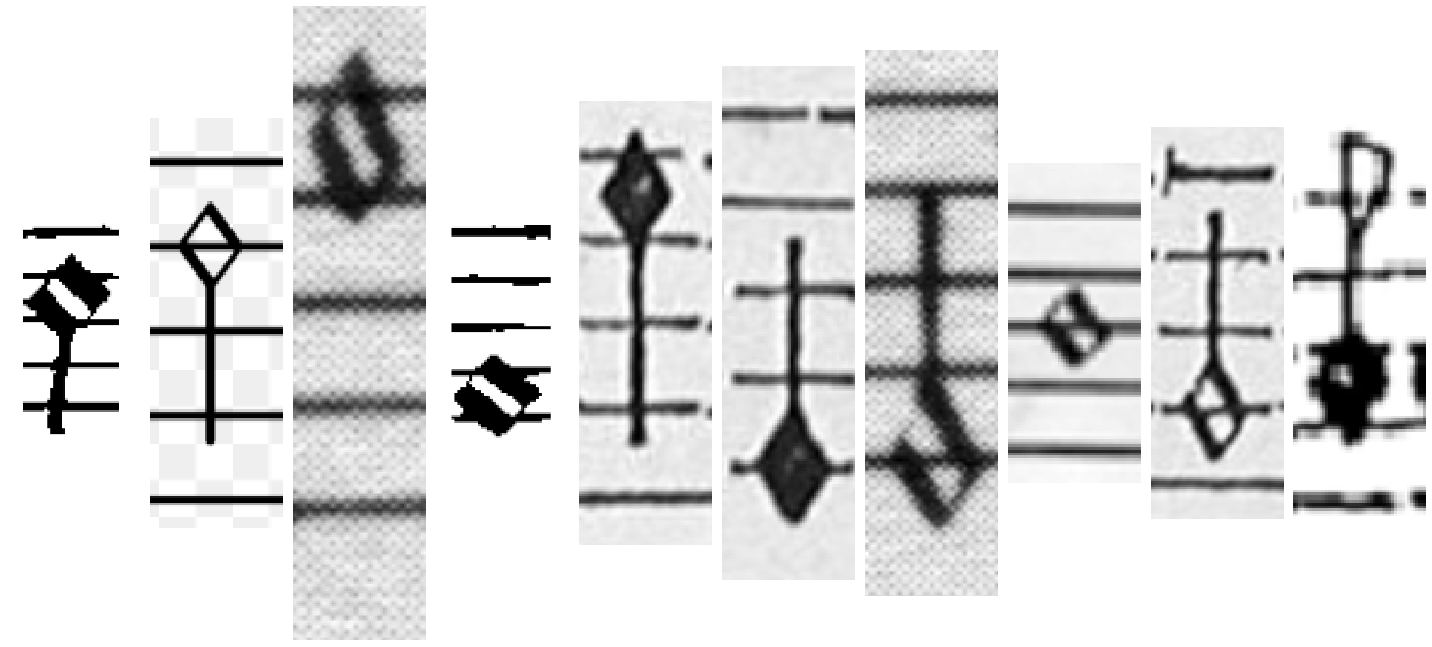

In [26]:
plotImages(images_test_original, 'test_original')

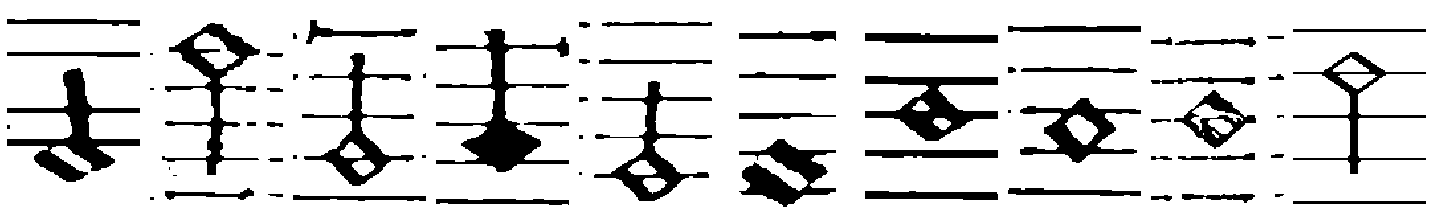

In [27]:
plotImages(images_test, 'test_preprocessed')

In [0]:
data_test = np.array(data_test)

In [29]:
set(noteLabels_test)
set(durationLabels_test)
len(set(map(len, (data_test, noteLabels_test, durationLabels_test)))) == 1 #check if length of lists is the same

{"a'", "b'", "c''", "d'", "d''", "e'", "e''", "f'", "f''", "g'", "g''"}

{'1', '2', '4', '8', 'breve'}

True

In [0]:
# convert the label lists to NumPy arrays prior to binarization
noteLabels_test = np.array(noteLabels_test)
durationLabels_test = np.array(durationLabels_test)
 
# binarize both sets of labels
noteLabels_test = noteLB.transform(noteLabels_test)
durationLabels_test = durationLB.transform(durationLabels_test)

"a'"

'1'

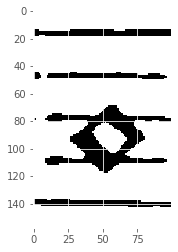

"a'"

'4'

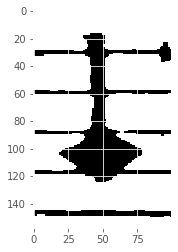

"d''"

'4'

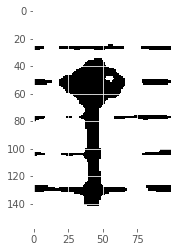

In [31]:
# double check if testimages are correctly labeled

noteLB.inverse_transform(noteLabels_test)[0]
durationLB.inverse_transform(durationLabels_test)[0]

plt.imshow(np.squeeze(data_test[0]), cmap = 'gray')
plt.show()

noteLB.inverse_transform(noteLabels_test)[1]
durationLB.inverse_transform(durationLabels_test)[1]

plt.imshow(np.squeeze(data_test[1]), cmap = 'gray')
plt.show()

noteLB.inverse_transform(noteLabels_test)[15]
durationLB.inverse_transform(durationLabels_test)[15]

plt.imshow(np.squeeze(data_test[15]), cmap = 'gray')
plt.show()

In [32]:
# classify test images with model
scores = model.evaluate(data_test, [noteLabels_test, durationLabels_test], verbose=0)

print("[INFO] Total Loss: {:.5f}".format(scores[0]))  
print("[INFO] Note Loss: {:.5f}".format(scores[1])) 
print("[INFO] Duration Loss: {:.5f}".format(scores[2]))  
print("[INFO] Note Accuracy: {:.2f}%".format(scores[3]*100)) 
print("[INFO] Duration Accuracy: {:.2f}%".format(scores[4]*100)) 

[INFO] Total Loss: 3.32201
[INFO] Note Loss: 2.02059
[INFO] Duration Loss: 1.30142
[INFO] Note Accuracy: 36.67%
[INFO] Duration Accuracy: 43.33%


In [0]:
note_pred, duration_pred = model.predict(data_test)
notes_preds = noteLB.inverse_transform(note_pred)
duration_preds = durationLB.inverse_transform(duration_pred)

In [0]:
note_true, duration_true = noteLabels_test.argmax(axis=-1), durationLabels_test.argmax(axis=-1)
note_pred, duration_pred = note_pred.argmax(axis=-1), duration_pred.argmax(axis=-1)

In [35]:
print("Classification report for notes")
print(classification_report(note_true, note_pred))

print("\nClassification report for duration")
print(classification_report(duration_true, duration_pred))

Classification report for notes
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.60      0.60      0.60         5
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.60      0.75      0.67         4
           5       0.40      0.67      0.50         3
           6       0.50      0.25      0.33         4
           7       0.00      0.00      0.00         1
           8       0.20      1.00      0.33         1
           9       0.00      0.00      0.00         3
          10       1.00      1.00      1.00         1

    accuracy                           0.37        30
   macro avg       0.30      0.39      0.31        30
weighted avg       0.33      0.37      0.33        30


Classification report for duration
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
          

In [0]:
model.save('InceptionV3_lily.h5')